##Data Load

In [1]:
from google.colab import drive
drive.mount('/content/drive')
df = '/content/drive/MyDrive/2022-산업공학종합설계/LSWMD.pkl'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

In [ ]:
from keras.layers import MaxPooling2D
from keras.layers import MaxPool2D
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [3]:
import tensorflow as tf
import keras
from keras import layers, Input, models
from tensorflow.keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_pickle(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811457 entries, 0 to 811456
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   waferMap        811457 non-null  object 
 1   dieSize         811457 non-null  float64
 2   lotName         811457 non-null  object 
 3   waferIndex      811457 non-null  float64
 4   trianTestLabel  811457 non-null  object 
 5   failureType     811457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 37.1+ MB


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df

,waferMap,dieSize,lotName,waferIndex,trianTestLabel,failureType
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,[[Training]],[[none]]
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,[[Training]],[[none]]
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,[[Training]],[[none]]
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,[[Training]],[[none]]
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,[[Training]],[[none]]
...,...,...,...,...,...,...
811452,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,23.0,[[Test]],[[Edge-Ring]]
811453,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1,...",600.0,lot47542,24.0,[[Test]],[[Edge-Loc]]
811454,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1,...",600.0,lot47542,25.0,[[Test]],[[Edge-Ring]]
811455,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",600.0,lot47543,1.0,[],[]


In [7]:
#웨이퍼 인덱스별 데이터는 분류기능에는 필요하지 않다고 판단되어 제거
df = df.drop(['waferIndex'],axis = 1)
df = df.drop(['trianTestLabel'],axis = 1)

In [8]:
#필요한 웨이퍼의 해상도별로 뽑아내기 위해 생성
def make_dim(x):
    dim0=np.size(x,axis=0)
    dim1=np.size(x,axis=1)
    return dim0,dim1
df['waferMapDim']=df.waferMap.apply(make_dim)

# 웨이퍼 사이즈
def wafer_size(x):
    a = np.size(x,axis=0)
    b = np.size(x,axis=1)
    pi = 3.14
    return a*b*pi
df['wafersize']=df.waferMap.apply(wafer_size)

df.sample(10)

,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize
486243,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",710.0,lot30099,[],"(32, 29)",2913.92
329633,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",12662.0,lot19856,[[Edge-Ring]],"(107, 150)",50397.00
35536,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1253.0,lot3286,[],"(40, 40)",5024.00
278516,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1636.0,lot17098,[],"(46, 46)",6644.24
708717,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",516.0,lot43375,[[none]],"(25, 27)",2119.50
131864,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3532.0,lot8636,[],"(64, 71)",14268.16
254974,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",4612.0,lot15778,[],"(81, 73)",18566.82
719922,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1256.0,lot43826,[[none]],"(41, 40)",5149.60
626851,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2,...",712.0,lot39375,[],"(32, 29)",2913.92
532336,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,...",710.0,lot33299,[],"(32, 29)",2913.92


In [9]:
# 웨이퍼의 사이즈
df['netdieSize'] = df['wafersize']/df['dieSize']
df.sample(10)

,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdieSize
801816,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,...",562.0,lot47149,[[none]],"(29, 26)",2367.56,4.212740
96165,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2007.0,lot6754,[],"(42, 61)",8044.68,4.008311
167685,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",572.0,lot10682,[],"(22, 35)",2417.80,4.226923
648327,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot40680,[[Center]],"(26, 26)",2122.64,3.982439
733186,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",741.0,lot44365,[[none]],"(33, 29)",3004.98,4.055304
761415,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2,...",1109.0,lot45506,[[none]],"(39, 37)",4531.02,4.085681
342460,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",3850.0,lot20525,[],"(67, 73)",15357.74,3.989023
736217,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 2,...",741.0,lot44487,[[none]],"(33, 29)",3004.98,4.055304
648321,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 2, 1,...",533.0,lot40680,[[none]],"(26, 26)",2122.64,3.982439
496281,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1513.0,lot30790,[],"(49, 39)",6000.54,3.965988


In [10]:
#타원의 넓이와 원의 넓이는 다르며, 보통의 웨이퍼는 원인점을 감안하여 가장 샘플이 많은 26*26으로 진행
df['waferMapDim'].value_counts()

(32, 29)    108687
(25, 27)     64083
(49, 39)     39323
(26, 26)     30078
(30, 34)     29513
             ...  
(53, 70)         1
(99, 69)         1
(38, 50)         1
(45, 47)         1
(27, 71)         1
Name: waferMapDim, Length: 632, dtype: int64

In [11]:
ex_df = df.loc[df['waferMapDim'] == (26, 26)]

In [12]:
ex_df.reset_index(drop=True, inplace=True)

In [13]:
ex_df

,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdieSize
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
...,...,...,...,...,...,...,...
30073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30075,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30076,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439


In [14]:
ex_df = ex_df[ex_df.failureType != 'Center']

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [15]:
ex_df

,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdieSize
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
...,...,...,...,...,...,...,...
30073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30075,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30076,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439


In [16]:
ex_df = ex_df[ex_df.failureType != 'Donut']
ex_df

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdieSize
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 1,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2,...",533.0,lot7,[[none]],"(26, 26)",2122.64,3.982439
...,...,...,...,...,...,...,...
30073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30075,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30076,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439


In [17]:
ex_df = ex_df[ex_df.failureType != 'Loc']
ex_df = ex_df[ex_df.failureType != 'Near-full']
ex_df = ex_df[ex_df.failureType != 'Random']
ex_df = ex_df[ex_df.failureType != 'Scratch']
ex_df = ex_df[ex_df.failureType != 'none']
ex_df

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


,waferMap,dieSize,lotName,failureType,waferMapDim,wafersize,netdieSize
8,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 1, 2,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
9,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
11,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 2, 1,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
13,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
15,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 1, 1,...",533.0,lot7,[],"(26, 26)",2122.64,3.982439
...,...,...,...,...,...,...,...
30073,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30074,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 2, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30075,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439
30076,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2,...",533.0,lot42180,[],"(26, 26)",2122.64,3.982439


In [ ]:
# spac = ex_df[ex_df['failureType'].str.contains('Center','Donut','Loc','Near-full','Random','Scratch','none')].index
# ex_df = ex_df.drop(spac, inplace=True)

In [18]:
# wafermapdim이 해상도를 의미 / (26,26)인 wafer를 보자.
ex_wafer = ex_df['waferMap'].values

a = np.ones((1, 26, 26))
Type = list()

for i in range(len(ex_df)):
    # skip none
    if len(ex_df.iloc[i,:]['failureType']) == 0:
        continue
    a = np.concatenate((a, ex_df.iloc[i,:]['waferMap'].reshape(1, 26, 26)))
    Type.append(ex_df.iloc[i,:]['failureType'][0][0])

In [19]:
x = a[1:]
y = np.array(Type).reshape((-1,1))

In [20]:
print('x shape : {}, y shape : {}'.format(x.shape, y.shape))

x shape : (327, 26, 26), y shape : (327, 1)


In [21]:
#불량 클래스
faulty_case = np.unique(y)
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Edge-Loc : 296
Edge-Ring : 31


In [22]:
ex_df['dieSize'].unique()

array([533., 524., 520., 509., 534., 531., 504., 516., 515.])

In [23]:
ex_df['dieSize'].nunique()

9

In [ ]:
#####데이터 분석

In [ ]:
center_df = ex_df.loc[ex_df['failureType'] == 'Center']
Donut_df = ex_df.loc[ex_df['failureType'] == 'Donut']
Edge_Loc_df = ex_df.loc[ex_df['failureType'] == 'Edge-Loc']
Edge_Ring_df = ex_df.loc[ex_df['failureType'] == 'Edge-Ring']
Loc_df = ex_df.loc[ex_df['failureType'] == 'Loc']
Near_full_df = ex_df.loc[ex_df['failureType'] == 'Near-full']
Random_df = ex_df.loc[ex_df['failureType'] == 'Random']
Scratch_df = ex_df.loc[ex_df['failureType'] == 'Scratch']
none_df = ex_df.loc[ex_df['failureType'] == 'none']

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = libops.scalar_compare(x.ravel(), y, op)


In [ ]:
def average_netdie(df):
  x = len(df['netdieSize'])
  y = sum(df['netdieSize'])
  return y/x

In [ ]:
net_aver_list = (average_netdie(center_df),
average_netdie(Donut_df),
average_netdie(Edge_Loc_df),
average_netdie(Edge_Ring_df),
average_netdie(Loc_df),
average_netdie(Near_full_df),
average_netdie(Random_df),
average_netdie(Scratch_df),
average_netdie(none_df))

In [ ]:
faulty_case

array(['Center', 'Donut', 'Edge-Loc', 'Edge-Ring', 'Loc', 'Near-full',
       'Random', 'Scratch', 'none'], dtype='<U9')

In [ ]:
net_aver_list

(3.982439024390244,
 3.9824390243902434,
 3.9847935069215663,
 4.00813217938631,
 3.9824390243902545,
 3.9824390243902443,
 3.982439024390241,
 3.9838218157181537,
 3.982439024388996)

In [ ]:
# Center : 3.982439024390244
# Donut : 3.9824390243902434
# Edge-Loc : 3.9847935069215663 --1--
# Edge-Ring : 4.00813217938631 --2--
# Loc : 3.9824390243902545
# Near-full : 3.9824390243902443
# Random : 3.982439024390241
# Scratch : 3.9838218157181537
# none : 3.982439024388996

In [ ]:
faulty_case = np.unique(y)
for f in faulty_case:
  for i in net_aver_list:
    print('{} : {}'.format(f, i))

In [ ]:
####데이터 분석

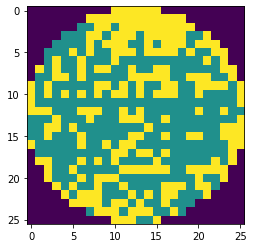

Faulty case : ['Edge-Loc'] 


In [24]:
plt.imshow(x[36])
plt.show()
print('Faulty case : {} '.format(y[36]))

In [25]:
x = x.reshape((-1, 26, 26, 1))

In [26]:
x.shape

(327, 26, 26, 1)

In [27]:
#불량 클래스
faulty_case = np.unique(y)
for f in faulty_case :
    print('{} : {}'.format(f, len(y[y==f])))

Edge-Loc : 296
Edge-Ring : 31


웨이퍼 데이터의 각 픽셀에는 웨이퍼가 아닌 0, 1: 정상, 2: 결함을 나타내는 범주형 변수가 있다. 원-핫 인코딩된 단일 범주 데이터를 채널로 사용하여 추가 차원을 확장한다.



In [28]:
len(x)

327

In [29]:
#각 채널에 따라 원핫인코딩
new_x = np.zeros((len(x), 26, 26, 3))

for w in range(len(x)):
    for i in range(26):
        for j in range(26):
            new_x[w, i, j,int(x[w, i, j])] = 1

In [30]:
new_x.shape

(327, 26, 26, 3)

##couv autoencoder

In [31]:
#인고더
input_shape = (26, 26, 3)
input_tensor = Input(input_shape)
encode = layers.Conv2D(64, (3,3), padding='same', activation='relu')(input_tensor)
Maxpool2D = layers.MaxPool2D()(encode)

#디코더
decode_layer_1 = layers.Conv2DTranspose(64, (3,3), padding='same', activation='relu')
decode_layer_2 = layers.UpSampling2D()
output_tensor = layers.Conv2DTranspose(3, (3,3), padding='same', activation='sigmoid')

#디코더 레이어 연걸
decode = decode_layer_1(Maxpool2D)
decode = decode_layer_2(decode)

ae = models.Model(input_tensor, output_tensor(decode))
ae.compile(optimizer = 'Adam',
              loss = 'mse',
             )

In [32]:
ae.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_transpose (Conv2DTra  (None, 13, 13, 64)       36928     
 nspose)                                                         
                                                                 
 up_sampling2d (UpSampling2D  (None, 26, 26, 64)       0         
 )                                                               
                                                             

In [33]:
# start train
# verbose 0이면 출력x, 1이면 자세히, 2이면 함축적 정보
ae.fit(new_x, new_x,
       batch_size=512,
       epochs=10,
       verbose=2)

Epoch 1/10
1/1 - 1s - loss: 0.2400 - 1s/epoch - 1s/step
Epoch 2/10
1/1 - 1s - loss: 0.2188 - 802ms/epoch - 802ms/step
Epoch 3/10
1/1 - 1s - loss: 0.2003 - 746ms/epoch - 746ms/step
Epoch 4/10
1/1 - 1s - loss: 0.1844 - 741ms/epoch - 741ms/step
Epoch 5/10
1/1 - 1s - loss: 0.1720 - 744ms/epoch - 744ms/step
Epoch 6/10
1/1 - 1s - loss: 0.1636 - 735ms/epoch - 735ms/step
Epoch 7/10
1/1 - 1s - loss: 0.1584 - 904ms/epoch - 904ms/step
Epoch 8/10
1/1 - 1s - loss: 0.1547 - 1s/epoch - 1s/step
Epoch 9/10
1/1 - 1s - loss: 0.1509 - 1s/epoch - 1s/step
Epoch 10/10
1/1 - 2s - loss: 0.1463 - 2s/epoch - 2s/step


In [34]:
#오토인코더 모델 층의 일부를 인코더 모델 생성
encoder = models.Model(input_tensor,Maxpool2D)

In [35]:
#오토인코더 모델 층의 일부로 디코더 모델 생성
decoder_input = Input((13, 13, 64))
decode = decode_layer_1(decoder_input)
decode = decode_layer_2(decode)
decoder = models.Model(decoder_input, output_tensor(decode))

In [36]:
#기존 결함이 있는 웨이퍼 인코딩
encoded_x = encoder.predict(new_x)

#노이즈 첨가
noised_encoded_x = encoded_x+np.random.normal(loc=0,
                                                scale=0.1,
                                                size = (len(encoded_x), 13, 13, 64))

In [37]:
###데이터 증강 - 3000개 정도
def gen_data(wafer, label):
    #인코더 웨이퍼
    encoded_x = encoder.predict(wafer)
    gen_x = np.zeros((1, 26, 26, 3))
    
    #3000개 데이터 증강
    for i in range((2000//len(wafer)) + 1):
        noised_encoded_x = encoded_x + np.random.normal(loc=0, scale=0.1, size = (len(encoded_x), 13, 13, 64)) 
        noised_gen_x = decoder.predict(noised_encoded_x)
        gen_x = np.concatenate((gen_x, noised_gen_x), axis=0)

    gen_y = np.full((len(gen_x), 1), label)

    return gen_x[1:], gen_y[1:]

In [38]:
#모든 결함있는 경우의 데이터를 증강
for f in faulty_case:
    if f == 'none': 
        continue
    gen_x, gen_y = gen_data(new_x[np.where(y==f)[0]],f)
    new_x = np.concatenate((new_x, gen_x),axis=0)
    y = np.concatenate((y,gen_y))

In [39]:
print('수정 후 new_x shape : {}, new_y shape : {}'.format(new_x.shape, y.shape))

수정 후 new_x shape : (4414, 26, 26, 3), new_y shape : (4414, 1)


In [40]:
for f in faulty_case:
    print('{} : {}'.format(f, len(y[y==f])))

Edge-Loc : 2368
Edge-Ring : 2046


In [94]:
# #사이즈 확인
# none_idx = np.where(y=='Edge-Ring')[0][np.random.choice(len(np.where(y=='Edge-Ring')[0]), size=11000)]
# new_x = np.delete(new_x, none_idx, axis=0)
# new_y = np.delete(y, none_idx, axis=0)

In [95]:
# print('After Delete "none" class new_x shape : {}, new_y shape : {}'.format(new_x.shape, new_y.shape))

After Delete "none" class new_x shape : (2376, 26, 26, 3), new_y shape : (2376, 1)


In [96]:
# for f in faulty_case:
#     print('{} : {}'.format(f, len(new_y[new_y==f])))

Edge-Loc : 2368
Edge-Ring : 8


In [42]:
new_y = y
for i, j in enumerate(faulty_case):
    new_y[new_y==j] = i
# 원핫인코딩
new_y = to_categorical(new_y)

In [43]:
new_y.shape

(4414, 2)

In [44]:
x_train, x_test, y_train, y_test = train_test_split(new_x, new_y,
                                                    test_size=0.3,
                                                    random_state=64)

In [45]:
print('Train x : {}, y : {}'.format(x_train.shape, y_train.shape))
print('Test x: {}, y : {}'.format(x_test.shape, y_test.shape))

Train x : (3089, 26, 26, 3), y : (3089, 2)
Test x: (1325, 26, 26, 3), y : (1325, 2)


##CNN

In [ ]:
# def CNN_1():
#     input_shape = (26, 26, 3)
#     input = Input(input_shape)

#     conv1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input)
#     maxpool1 = layers.Maxpool2D(2,2)
#     conv2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv1)
#     maxpool2 = layers.Maxpool2D(2,2)
#     conv3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv2)

#     flat = layers.Flatten()(conv3)

#     dense1 = layers.Dense(512, activation='relu')(flat) #512개 레이어 노드
#     dense2 = layers.Dense(128, activation='relu')(dense1) #128
#     output = layers.Dense(9, activation='softmax')(dense2) #9

#     model = models.Model(input, output)
#     model.compile(optimizer='Adam',
#                  loss='categorical_crossentropy',
#                  metrics=['accuracy'])

#     return model

In [51]:
def CNN():
    input_shape = (26, 26, 3)
    input = Input(input_shape)

    conv1 = layers.Conv2D(16, (3,3), activation='relu', padding='same')(input)
    conv2 = layers.Conv2D(64, (3,3), activation='relu', padding='same')(conv1)
    conv3 = layers.Conv2D(128, (3,3), activation='relu', padding='same')(conv2)

    flat = layers.Flatten()(conv3)

    dense1 = layers.Dense(512, activation='relu')(flat) #512개 레이어 노드
    dense2 = layers.Dense(128, activation='relu')(dense1) #128
    output = layers.Dense(2, activation='softmax')(dense2) #9

    model = models.Model(input, output)
    model.compile(optimizer='Adam',
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

    return model

In [52]:
CNN().summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 26, 26, 3)]       0         
                                                                 
 conv2d_16 (Conv2D)          (None, 26, 26, 16)        448       
                                                                 
 conv2d_17 (Conv2D)          (None, 26, 26, 64)        9280      
                                                                 
 conv2d_18 (Conv2D)          (None, 26, 26, 128)       73856     
                                                                 
 flatten_5 (Flatten)         (None, 86528)             0         
                                                                 
 dense_15 (Dense)            (None, 512)               44302848  
                                                                 
 dense_16 (Dense)            (None, 128)               6566

In [53]:
model = KerasClassifier(build_fn = CNN, epochs=5, batch_size=1024, verbose=2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [54]:
# 3-Fold Crossvalidation - 10번 질러볼까...
kfold = KFold(n_splits=3, shuffle=True, random_state=64)
result = cross_val_score(model, x_train, y_train, cv=kfold)
print('CNN Cross validation score : {:.5f}'.format(np.mean(result)))

Epoch 1/5
3/3 - 28s - loss: 1.4424 - accuracy: 0.5270 - 28s/epoch - 9s/step
Epoch 2/5
3/3 - 26s - loss: 0.6806 - accuracy: 0.5396 - 26s/epoch - 9s/step
Epoch 3/5
3/3 - 28s - loss: 0.6650 - accuracy: 0.5367 - 28s/epoch - 9s/step
Epoch 4/5
3/3 - 28s - loss: 0.6578 - accuracy: 0.5367 - 28s/epoch - 9s/step
Epoch 5/5
3/3 - 30s - loss: 0.6558 - accuracy: 0.5367 - 30s/epoch - 10s/step
2/2 - 4s - loss: 0.6639 - accuracy: 0.5505 - 4s/epoch - 2s/step
Epoch 1/5
3/3 - 30s - loss: 3.3690 - accuracy: 0.5430 - 30s/epoch - 10s/step
Epoch 2/5
3/3 - 26s - loss: 0.8386 - accuracy: 0.4575 - 26s/epoch - 9s/step
Epoch 3/5
3/3 - 28s - loss: 0.6823 - accuracy: 0.5425 - 28s/epoch - 9s/step
Epoch 4/5
3/3 - 26s - loss: 0.6775 - accuracy: 0.5425 - 26s/epoch - 9s/step
Epoch 5/5
3/3 - 26s - loss: 0.6690 - accuracy: 0.5425 - 26s/epoch - 9s/step
2/2 - 4s - loss: 0.6559 - accuracy: 0.5388 - 4s/epoch - 2s/step
Epoch 1/5
3/3 - 27s - loss: 1.7199 - accuracy: 0.4942 - 27s/epoch - 9s/step
Epoch 2/5
3/3 - 28s - loss: 0.8179

In [55]:
#학습
history = model.fit(x_train, y_train,
         validation_data=[x_test, y_test],
         epochs=5,
         batch_size=512,
         )

Epoch 1/5
7/7 - 48s - loss: 1.0940 - accuracy: 0.5231 - val_loss: 0.6667 - val_accuracy: 0.5253 - 48s/epoch - 7s/step
Epoch 2/5
7/7 - 46s - loss: 0.6588 - accuracy: 0.5743 - val_loss: 0.6492 - val_accuracy: 0.6279 - 46s/epoch - 7s/step
Epoch 3/5
7/7 - 45s - loss: 0.6370 - accuracy: 0.6436 - val_loss: 0.6003 - val_accuracy: 0.8083 - 45s/epoch - 6s/step
Epoch 4/5
7/7 - 47s - loss: 0.5381 - accuracy: 0.8362 - val_loss: 0.4550 - val_accuracy: 0.7879 - 47s/epoch - 7s/step
Epoch 5/5
7/7 - 45s - loss: 0.3875 - accuracy: 0.8339 - val_loss: 0.5569 - val_accuracy: 0.7343 - 45s/epoch - 6s/step


In [56]:
score = model.score(x_test, y_test)
print('Model Accuracy:',score)

2/2 - 5s - loss: 0.5569 - accuracy: 0.7343 - 5s/epoch - 2s/step
Model Accuracy: 0.7343395948410034
